# Imports

In [17]:
import numpy as np
import pandas as pd
from asapdiscovery.docking import analysis as a
from importlib import reload
reload(a)
from asapdiscovery.data.schema_v2.ligand import Ligand
from asapdiscovery.data.schema_v2.complex import Complex
from asapdiscovery.data.selectors.mcs_selector import MCSSelector
from openeye import oegraphsim
from tqdm import tqdm
from pathlib import Path
import json
from itertools import combinations # only need to do the combinations once since the Tanimoto is symmetric

## Load the data

In [18]:
data_path = Path("../../data/20240202_fragalysis_p_series_schema")

In [19]:
complexes = [Complex.from_dict(json.load(open(p))) for p in data_path.glob("*.json")]

In [20]:
mols = [c.ligand for c in complexes]

In [191]:
def get_fp(mol, bit_size=2048, radius=2):
    fp = oegraphsim.OEFingerPrint()
    oegraphsim.OEMakeCircularFP(fp, mol, bit_size, 0, radius, oegraphsim.OEFPAtomType_DefaultCircularAtom, oegraphsim.OEFPBondType_DefaultCircularBond)
    return fp

In [126]:
oegraphsim.OEGetFPAtomType(oegraphsim.OEFPAtomType_DefaultCircularAtom)

'AtmNum|Arom|Chiral|FCharge|HCount|EqHalo'

In [127]:
fps = [get_fp(mol.to_oemol()) for mol in mols]

In [128]:
def calculate_tanimoto(fp1, fp2):
    return oegraphsim.OETanimoto(fp1, fp2)

In [129]:
tc_list = [calculate_tanimoto(fp1, fp2) for fp1 in fps for fp2 in fps]

In [130]:
tc_matrix = np.array(tc_list).reshape(len(fps), len(fps))

In [131]:
import plotly.express as px

In [132]:
px.imshow(tc_matrix)

In [139]:
df = pd.DataFrame({"Mol1": [m.compound_name for m in mols for _ in mols], "Mol2": [m.compound_name for _ in mols for m in mols], "Tanimoto": tc_list})

In [151]:
df_filtered = df[df["Mol1"] != df["Mol2"]]

In [154]:
top10_df = df_filtered.groupby(['Mol1']).head(10)

In [168]:
top_df = df_filtered.groupby(['Mol1']).head(1)

In [169]:
mean_df = top10_df.groupby(['Mol1'])[["Tanimoto"]].mean().reset_index()

In [177]:
px.strip(top10_df, x="Mol1", y="Tanimoto", category_orders={"Mol1": mean_df.sort_values("Tanimoto")["Mol1"]})

In [213]:
def get_tc_df(mols, bit_size=2048, radius=2):
    fps = [get_fp(mol.to_oemol(), bit_size, radius) for mol in mols]
    tc_list = [calculate_tanimoto(fp1, fp2) for fp1 in fps for fp2 in fps]
    df = pd.DataFrame({"Mol1": [m.compound_name for m in mols for _ in mols], 
                       "Mol2": [m.compound_name for _ in mols for m in mols], 
                       "Tanimoto": tc_list,
                       "Fingerprint": f"ECFP{2*radius}",
                       "BitSize": f"{bit_size} bits"})
    df_filtered = df[df["Mol1"] != df["Mol2"]]
    return df_filtered

In [222]:
dfs = []
for radius in [2, 3, 4, 5]:
    for bit_size in [2048]:
        df = get_tc_df(mols, bit_size, radius)
        dfs.append(df)

In [223]:
all_df = pd.concat(dfs)

In [278]:
all_df.to_csv("tanimoto_fingerprint_comparison.csv", index=False)

In [224]:
all_top_df = all_df.groupby(['Mol1', 'Fingerprint']).head(1)

In [225]:
px.histogram(all_top_df, 
             x="Tanimoto", 
             nbins=20, 
             title="Tanimoto similarity between the most similar ligands", 
             range_x=[0, 1], 
             template="plotly_white", 
             labels={"Tanimoto": "Tanimoto similarity (ECFP4 Fingerprints)"},
                color="Fingerprint",
             barmode="overlay",
             opacity=0.75)

/Users/alexpayne/miniforge-pypy3/envs/asapdiscovery/lib/python3.10/site-packages/plotly/express/_core.py:2065: FutureWarning:

When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.



## kde distplot

In [271]:
import plotly.figure_factory as ff

In [272]:
hist_data = [all_top_df[all_top_df["Fingerprint"] == fp]["Tanimoto"] for fp in all_top_df.Fingerprint.unique()]

In [273]:
fig = ff.create_distplot(hist_data, 
                         group_labels=[fp for fp in all_top_df.Fingerprint.unique()], 
                         bin_size=0.1, 
                         histnorm="probability", 
                         show_rug=False,
                         show_hist=False)

In [274]:
fig.update_xaxes(range=[0, 1])
fig.update_yaxes(range=[0, 1])
fig.update_layout(template="simple_white", 
                  title="Maximum Tanimoto similarities in this dataset", 
                  xaxis_title="Tanimoto similarity", 
                  yaxis_title="Probability", 
                  height=400, 
                  width=600,
                  legend=dict(title="Fingerprint Type", y=0.5, x=0.8))
fig.write_image("tanimoto_kde.svg")

## add MCSS to the mix

In [275]:
mcss_hist_data = np.load("mcss_tanimoto.npy")

In [276]:
fig = ff.create_distplot(hist_data + [mcss_hist_data], 
                         group_labels=[fp for fp in all_top_df.Fingerprint.unique()] + ["Number of Atoms in the MCSS"], 
                         bin_size=0.1, 
                         histnorm="probability", 
                         show_rug=False,
                         show_hist=False)

In [277]:
fig.update_xaxes(range=[0, 1])
fig.update_yaxes(range=[0, 1])
fig.update_layout(template="simple_white", 
                  title="Maximum Tanimoto similarities in this dataset", 
                  xaxis_title="Tanimoto similarity", 
                  yaxis_title="Probability", 
                  height=400, 
                  width=600,
                  legend=dict(title="Fingerprint Type", y=0.5, x=0.8))
fig.write_image("tanimoto_kde.svg")

In [121]:
mol1 = mols[72]
mol2 = mols[52]

In [122]:
from rdkit import Chem

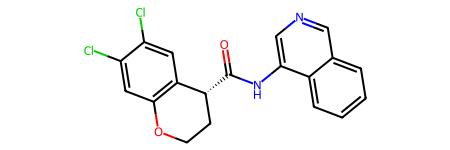

In [123]:
Chem.MolFromSmiles(mol1.smiles)

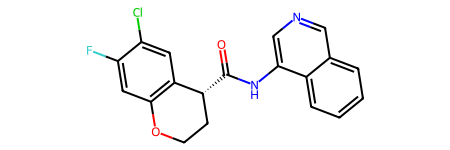

In [124]:
Chem.MolFromSmiles(mol2.smiles)

In [67]:
from rdkit.Chem import MACCSkeys, rdFingerprintGenerator, DataStructs

In [116]:
fpg = rdFingerprintGenerator.GetMorganGenerator(radius=2, fpSize=2048)

In [117]:
fp1 = fpg.GetFingerprint(Chem.MolFromSmiles(mol1.smiles))

In [118]:
fp2 = fpg.GetFingerprint(Chem.MolFromSmiles(mol2.smiles))

In [119]:
DataStructs.TanimotoSimilarity(fp1, fp2)

0.7407407407407407

In [73]:
tc_matrix[97, 143]

0.5428571701049805

In [74]:
tc_matrix[143, 97]

0.5428571701049805

In [78]:
fptype = oegraphsim.OEGetFPType(oegraphsim.OEFPType_Circular)
print(fptype.GetFPTypeString())

Circular,ver=2.0.0,size=4096,radius=0-5,atype=AtmNum|Arom|Chiral|FCharge|HCount|EqHalo,btype=Order
